In [1]:
library(ggplot2)
library(dplyr)
library(gplots)
library(pvclust)
library(ggpmisc)
library(ggpubr)
library(reshape2)
library(umap)
library(ggExtra) 
library(pals)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)
library(heatmap.plus)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: ggpp

Registered S3 methods overwritten by 'ggpp':
  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate


Registered S3 method overwritten by 'ggpmisc':
  method                  from   
  as.character.polynomial polynom

Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite eit

# analyze with Bulk tissue and 287_variant_annotation_bulk_sort_COUPTF2_TBR1_DLX1_CBH annotation file

In [2]:
filtered <- read.table("../7614_final_summary_anno3.txt",header=T,sep="\t")
variant_list <- read.csv("../variant_annotation/287_variant_annotation_bulk_sort_COUPTF2_TBR1_DLX1_CBH.csv",header=T,sep=",", row.names = 1)
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] #Use 269 variants. assign this to mosaic_filtered
shared_variant_list<-variant_list[variant_list$sample_number_presented>0]#sample_number_presented_CBH>1,]
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]

In [3]:
melt_mtcars<-mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region", "Cell_Type", "Note")]
#melt_mtcars<-na.omit(melt_mtcars)
melt_mtcars<-na.omit(melt_mtcars[melt_mtcars$CHROM.POS.REF.ALT %in% variant_list[variant_list$sample_number_presented>1,]$variant_list,])
                                 #shared_variant_list$variant_list,])
#melt_mtcars<-melt_mtcars[melt_mtcars$ID %in% c('7614-L-5-put','7614-L-5-thal','7614-L-9-ins','7614-Sml-L-F-029','7614-Sml-L-O-57',
#                                               '7614-Sml-L-P-043','7614-Sml-L-PF-015','7614-Sml-L-T-001','7614-L-6-thal','7614-L-7-thal','7614-L-8-thal',
#                                               '7614-L-5-hip','7614-L-6-CA1','7614-L-6-CA3','7614-L-6-DG','7614-L-6-sub','7614-L-7-CA1','7614-L-7-CA3',
#                                               '7614-L-7-DG','7614-L-7-sub'),]

melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('Bulk'),]
melt_mtcars<-melt_mtcars[!melt_mtcars$Note %in% c('LARGE'),]

#melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('DLX1','TBR1','COUPTF2'),]
melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX','BG','HIP')),]

#melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX','BG','AMG','HIP','THAL','SUB','CLO')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Region %in% c('P','T','O','Ins','PF','F'),]
melt_mtcars<-melt_mtcars[melt_mtcars$Hemisphere %in% c('L'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Punch %in% c('1'),]

melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)

In [4]:
melt_mtcars<-na.omit(melt_mtcars)
length(unique(melt_mtcars$CHROM.POS.REF.ALT))

[1] 146

In [5]:
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+Hemisphere+Region+Organ+Cell_Type~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1]
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$Hemisphere)
unique(casted_MAF_VarBySample2$Organ)
unique(casted_MAF_VarBySample2$Region)
unique(casted_MAF_VarBySample2$Cell_Type)

[1] 30

[1] "L"

[1] "BG"  "HIP" "CTX"

[1] "Cau" "GP"  "Put" "Hip" "CA1" "CA3" "DG"  "Ins" "F"   "O"   "P"   "PF" 
[13] "T"

[1] "Bulk"

In [6]:
Normalized_casted_MAF_VarBySample2<-t(na.omit(t(casted_MAF_VarBySample2[,-1:-4])))
label<-t(na.omit(t(casted_MAF_VarBySample2[,1:4])))
label<-as.data.frame(label)

In [7]:
left_right_cell_col_ann <- HeatmapAnnotation(simple_anno_size = unit(0.5, "cm"), 
                                             which = "row",
                                             #Hemisphere = label$Hemisphere,
                                             Organ = label$Organ,
                                             Region = label$Region,
                                             #Cell_Type = label$Cell_Type,
                                             col = list(Organ = c("BG"="#CBDF00","CTX"="#00DF3D","HIP"="#9200DF"),
                                                       Region = c("Cau"="#A49A00",
                                                                  "GP"="#8EA400",
                                                                  "Put"="#75A400",
                                                                  "Hip"="#7E00A4",
                                                                  "CA1"="#9000A4",
                                                                  "CA3"="#A4009C",
                                                                  "DG"="#A4007E",
                                                                  "Ins"="#28A400",
                                                                  "F"="#14A400",
                                                                  "O"="#00A40F",
                                                                  "P"="#00A437",
                                                                  "PF"="#00A46B",
                                                                  "T"="#00A48B"))
                                             )

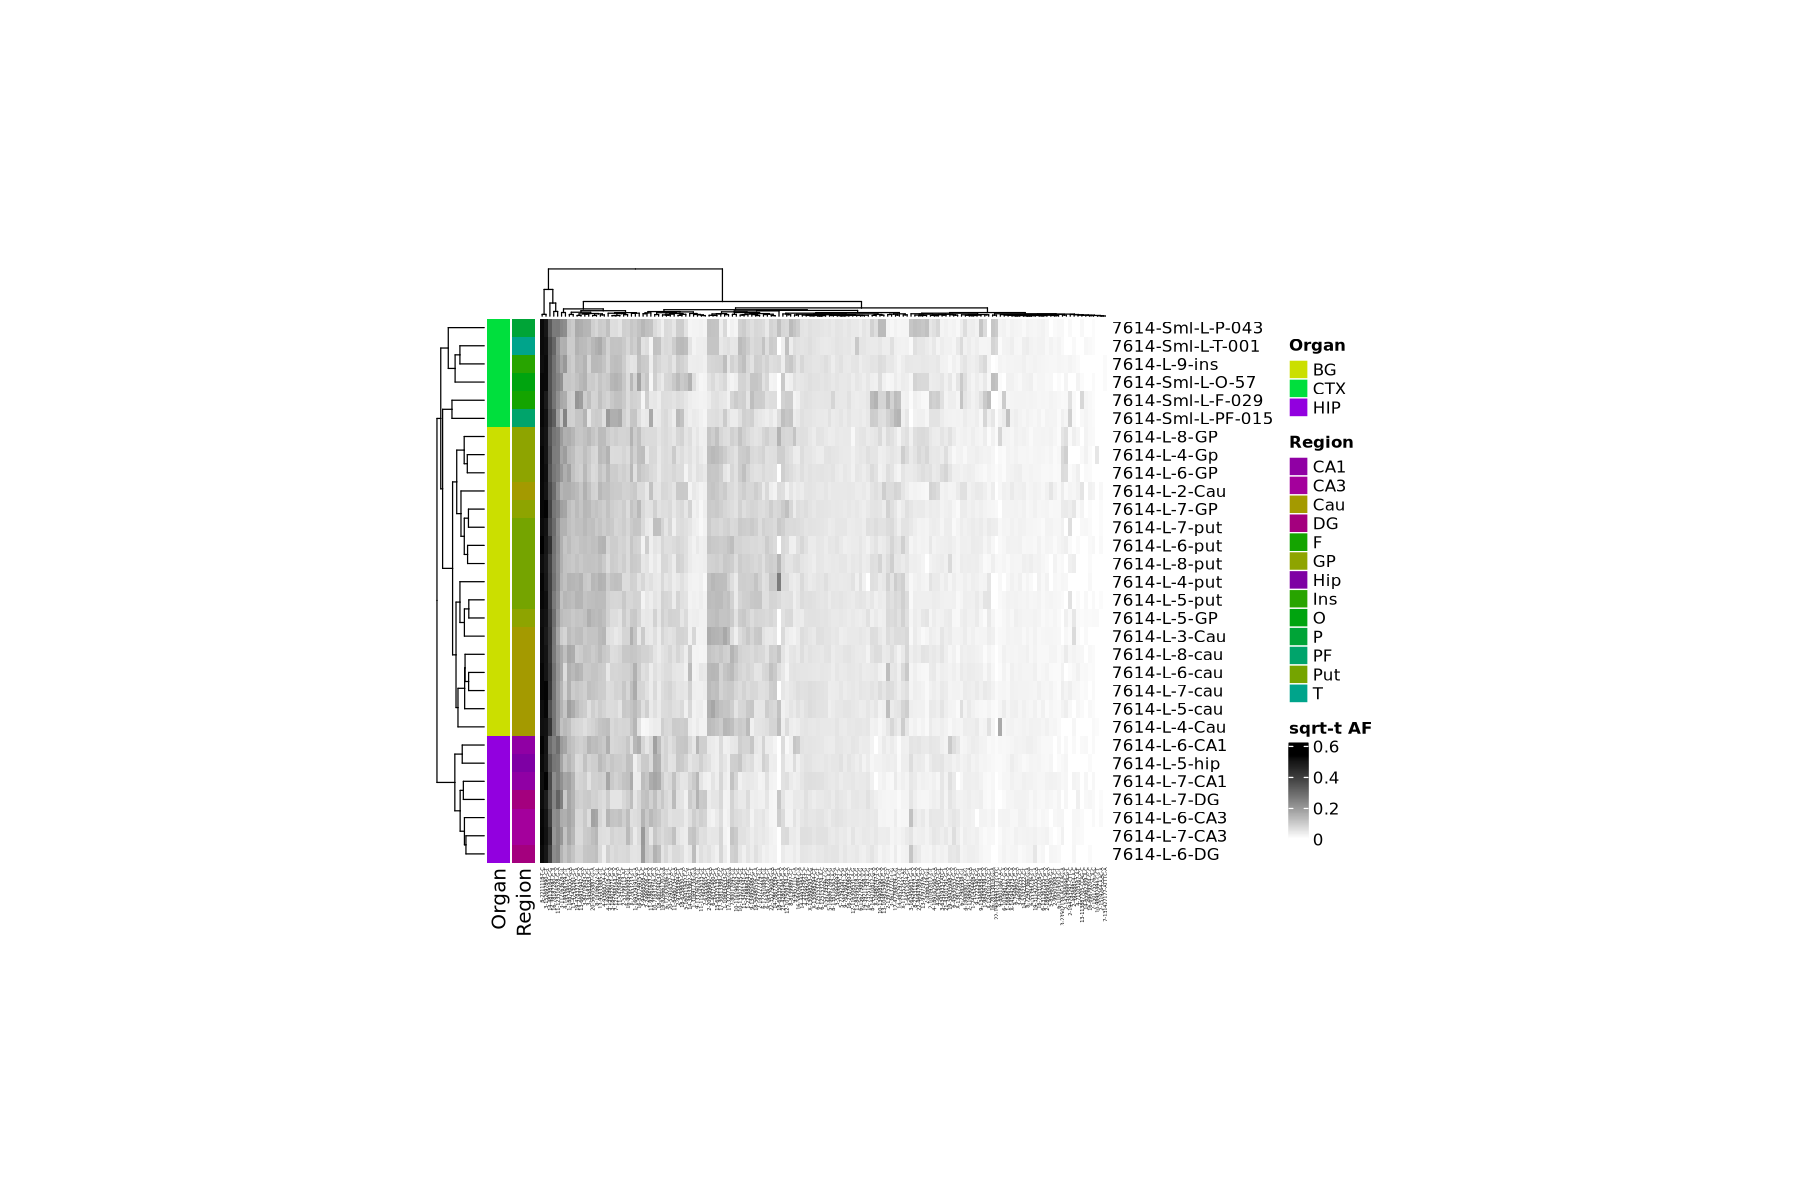

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)
p<-Heatmap(Normalized_casted_MAF_VarBySample2,
        col = c("white", "black"),
        row_names_gp = gpar(fontsize = "10"), column_names_gp = gpar(fontsize = "3"),
        name = "sqrt-t AF",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(12, "cm"),
        heatmap_height = unit(14, "cm")) 
p

In [9]:
pdf(file="7614_CTX_BG_HIP_Bulk_SampleByVar_heatmap.pdf",height=50,width=50)
p
dev.off()

png 
  2

# Bias plot with bulk data

In [68]:
shared_variant_list<-variant_list[variant_list$sample_number_presented_CBH>0,]#sample_number_presented sample_number_presented_CBH>1,]
working_variants<-shared_variant_list$variant_list
CTX <- subset(melt_mtcars, Organ %in% c('CTX'))
BG <- subset(melt_mtcars, Organ %in% c('BG'))
HIP <- subset(melt_mtcars, Organ %in% c('HIP'))
length(working_variants)
sum(CTX$MAF, na.rm = TRUE)/length(CTX$MAF)
sum(BG$MAF, na.rm = TRUE)/length(BG$MAF)
sum(HIP$MAF, na.rm = TRUE)/length(HIP$MAF)

delta<-data.frame()
for (i in 1:length(working_variants)){
    xx<-subset(CTX, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(BG, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,1]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }

for (i in 1:length(working_variants)){
    xx<-subset(CTX, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(HIP, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,2]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }

[1] 121

[1] 0.0679981

[1] 0.06478416

[1] 0.0596322

In [69]:
delta<-na.omit(delta)

In [70]:
nrow(delta)

[1] 113

In [71]:
mean(delta[,1])
mean(delta[,2])
SEM_X<-sd(delta[,1]) / sqrt(length(delta[,1]))
SEM_Y<-sd(delta[,2]) / sqrt(length(delta[,2]))
lowerX<-mean(delta[,1])-SEM_X
upperX<-mean(delta[,1])+SEM_X
lowerY<-mean(delta[,2])-SEM_Y
upperY<-mean(delta[,2])+SEM_Y

[1] 0.2155623

[1] 0.3339614

png 
  2

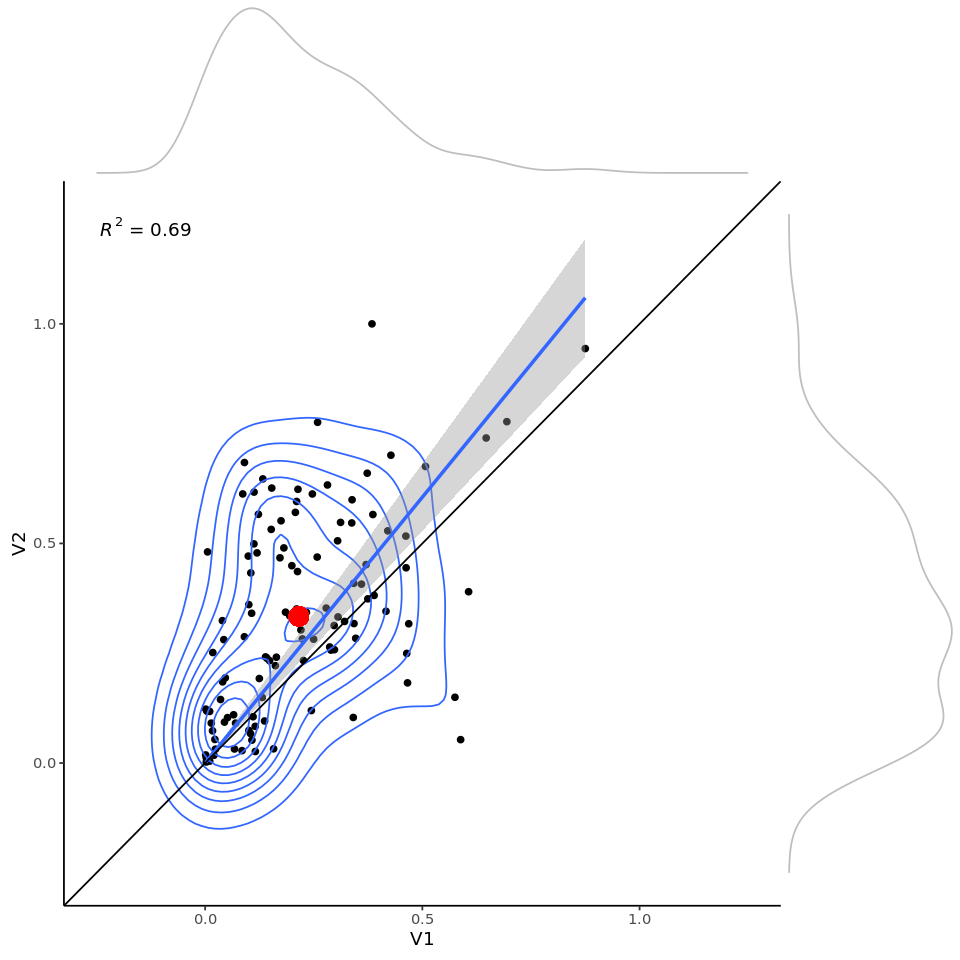

In [72]:
options(repr.plot.width = 8, repr.plot.height = 8)
formula <- y ~ x+0
p<-ggplot(delta, aes(x=V1, y=V2)) + geom_point()+xlim(-0.25,1.25)+ylim(-0.25,1.25)+theme_classic()+
    geom_density_2d()+stat_smooth(method = "lm", formula = y ~ x+0, geom = "smooth")+geom_abline(slope=1, intercept=0)+stat_poly_eq(formula = y ~ x+0,method = "lm")+
    geom_point(x = mean(delta[,1]), y = mean(delta[,2]), aes(x, y), size = 5, color = "red")
ggMarginal(p, color="grey", size=4)
pdf(file="7614_Bulk_CTX_BG_HIP_bias_plot.pdf",height=8,width=8)
 ggMarginal(p, color="grey", size=4)
 dev.off()    

# analyze with selected nuclei and 287_variant_annotation_bulk_sort_COUPTF2_TBR1_DLX1_CBH

In [73]:
filtered <- read.table("../7614_final_summary_anno3.txt",header=T,sep="\t")
variant_list <- read.csv("../variant_annotation/287_variant_annotation_bulk_sort_COUPTF2_TBR1_DLX1_CBH.csv",header=T,sep=",", row.names = 1)
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] #Use 269 variants. assign this to mosaic_filtered
shared_variant_list<-variant_list[variant_list$sample_number_presented_CBH>0,]

In [74]:
melt_mtcars<-mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region", "Cell_Type", "CTX_BG_HIP_relationship")]
melt_mtcars<-na.omit(melt_mtcars[melt_mtcars$CHROM.POS.REF.ALT %in% shared_variant_list$variant_list,])
melt_mtcars<-melt_mtcars[melt_mtcars$CTX_BG_HIP_relationship %in% c('1'),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)

In [75]:
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+Hemisphere+Region+Organ+Cell_Type~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1]
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$Hemisphere)
unique(casted_MAF_VarBySample2$Organ)
unique(casted_MAF_VarBySample2$Region)
unique(casted_MAF_VarBySample2$Cell_Type)
dim(casted_MAF_VarBySample2)
casted_MAF_VarBySample2

[1] 17

[1] "L"

[1] "BG"  "HIP" "CTX"

[1] "Cau" "GP"  "Put" "CA1" "CA3" "DG"  "Ins" "F"   "O"   "P"   "PF"  "T"

[1] "DLX1" "TBR1"

[1]  17 125

,Hemisphere,Region,Organ,Cell_Type,1-106934533-C-T,1-169329191-G-A,1-180856518-T-G,1-188748555-G-A,1-221888654-T-C,1-31691734-G-A,⋯,9-76576921-A-G,9-9457115-T-A,X-10480747-T-A,X-117352547-A-T,X-124310752-C-T,X-130898293-A-G,X-130898294-C-T,X-54739596-C-G,X-62980946-T-C,X-77453233-C-T
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7614-L-2-Cau-DLX1,L,Cau,BG,DLX1,0.10338933,0.05666547,0.000000000,0.11425478,0.09934711,0.02937713,⋯,0.04536967,0.02063282,0.061043543,0.061426336,0.03569608,0.04765328,0.04605662,0.04408270,0.03822326,0.10331970
7614-L-3-Cau-DLX1,L,Cau,BG,DLX1,0.14630940,0.12332075,0.030208402,0.13284223,0.06294457,0.01809726,⋯,0.04693233,0.05031546,0.000000000,0.086537289,0.05919399,0.02978190,0.02978777,0.05729445,0.03381261,0.14334824
7614-L-4-GP-DLX1,L,GP,BG,DLX1,0.12098185,0.08452267,0.012553070,0.10568621,0.10395749,0.02188965,⋯,0.04603085,0.01695402,0.050984286,0.111157426,0.03339730,0.04809794,0.04265777,0.04546746,0.03189800,0.11091956
7614-L-4-Put-DLX1,L,Put,BG,DLX1,0.18223634,0.06530231,0.000000000,0.13242267,0.12265462,0.02731792,⋯,0.05110975,0.05352366,0.060401404,0.085422620,0.05029364,0.04120428,0.03686800,0.04970299,0.04541807,0.09479091
7614-L-5-Cau-DLX1,L,Cau,BG,DLX1,0.11688208,0.12562660,0.000000000,0.07751361,0.09577696,0.01807237,⋯,0.04273181,0.07181124,0.041831258,0.101342786,0.06205346,0.04009942,0.03714476,0.03541659,0.04322838,0.07644482
7614-L-5-Put-DLX1,L,Put,BG,DLX1,0.11585417,0.09627247,0.030890103,0.07100909,0.09179962,0.03410332,⋯,0.04219611,0.01649572,0.030881919,0.087446561,0.06700789,0.06081765,0.05424291,0.04848811,0.02241867,0.12624046
7614-L-6-CA1-TBR1,L,CA1,HIP,TBR1,0.01253284,0.09717561,0.009376969,0.02270968,0.04401322,0.10827360,⋯,0.03198874,0.01222607,0.011805627,0.071358446,0.01920026,0.05177804,0.05047206,0.04939441,0.03100496,0.06872221
7614-L-6-CA3-TBR1,L,CA3,HIP,TBR1,0.01903330,0.10581444,0.000000000,0.05980416,0.03747343,0.10487034,⋯,0.04302089,0.01060415,0.007902238,0.095509759,0.02114853,0.03960368,0.03565148,0.04698096,0.05079293,0.02238307
7614-L-6-DG-TBR1,L,DG,HIP,TBR1,0.02766064,0.00000000,0.020883244,0.03191941,0.03372437,0.01823616,⋯,0.04765508,0.02799463,0.017162483,0.157693925,0.00000000,0.03978416,0.03558403,0.03966505,0.02929165,0.01816381


In [76]:
Normalized_casted_MAF_VarBySample2<-t(na.omit(t(casted_MAF_VarBySample2[,-1:-4])))
label<-t(na.omit(t(casted_MAF_VarBySample2[,1:4])))
label<-as.data.frame(label)

In [77]:
left_right_cell_col_ann <- HeatmapAnnotation(simple_anno_size = unit(0.5, "cm"), 
                                             which = "row",
                                             #Hemisphere = label$Hemisphere,
                                             Organ = label$Organ,
                                             Region = label$Region,
                                             Cell_Type = label$Cell_Type,
                                             #Cell_Type = label$Cell_Type,
                                             col = list(Organ = c("BG"="#CBDF00","CTX"="#00DF3D","HIP"="#9200DF"),
                                                       Region = c("Cau"="#A49A00",
                                                                  "GP"="#8EA400",
                                                                  "Put"="#75A400",
                                                                  "Hip"="#7E00A4",
                                                                  "CA1"="#9000A4",
                                                                  "CA3"="#A4009C",
                                                                  "DG"="#A4007E",
                                                                  "Ins"="#28A400",
                                                                  "F"="#14A400",
                                                                  "O"="#00A40F",
                                                                  "P"="#00A437",
                                                                  "PF"="#00A46B",
                                                                  "T"="#00A48B"),
                                                       Cell_Type = c("DLX1" = "#EF6666", "TBR1" = "#7CBD42"))
                                             )

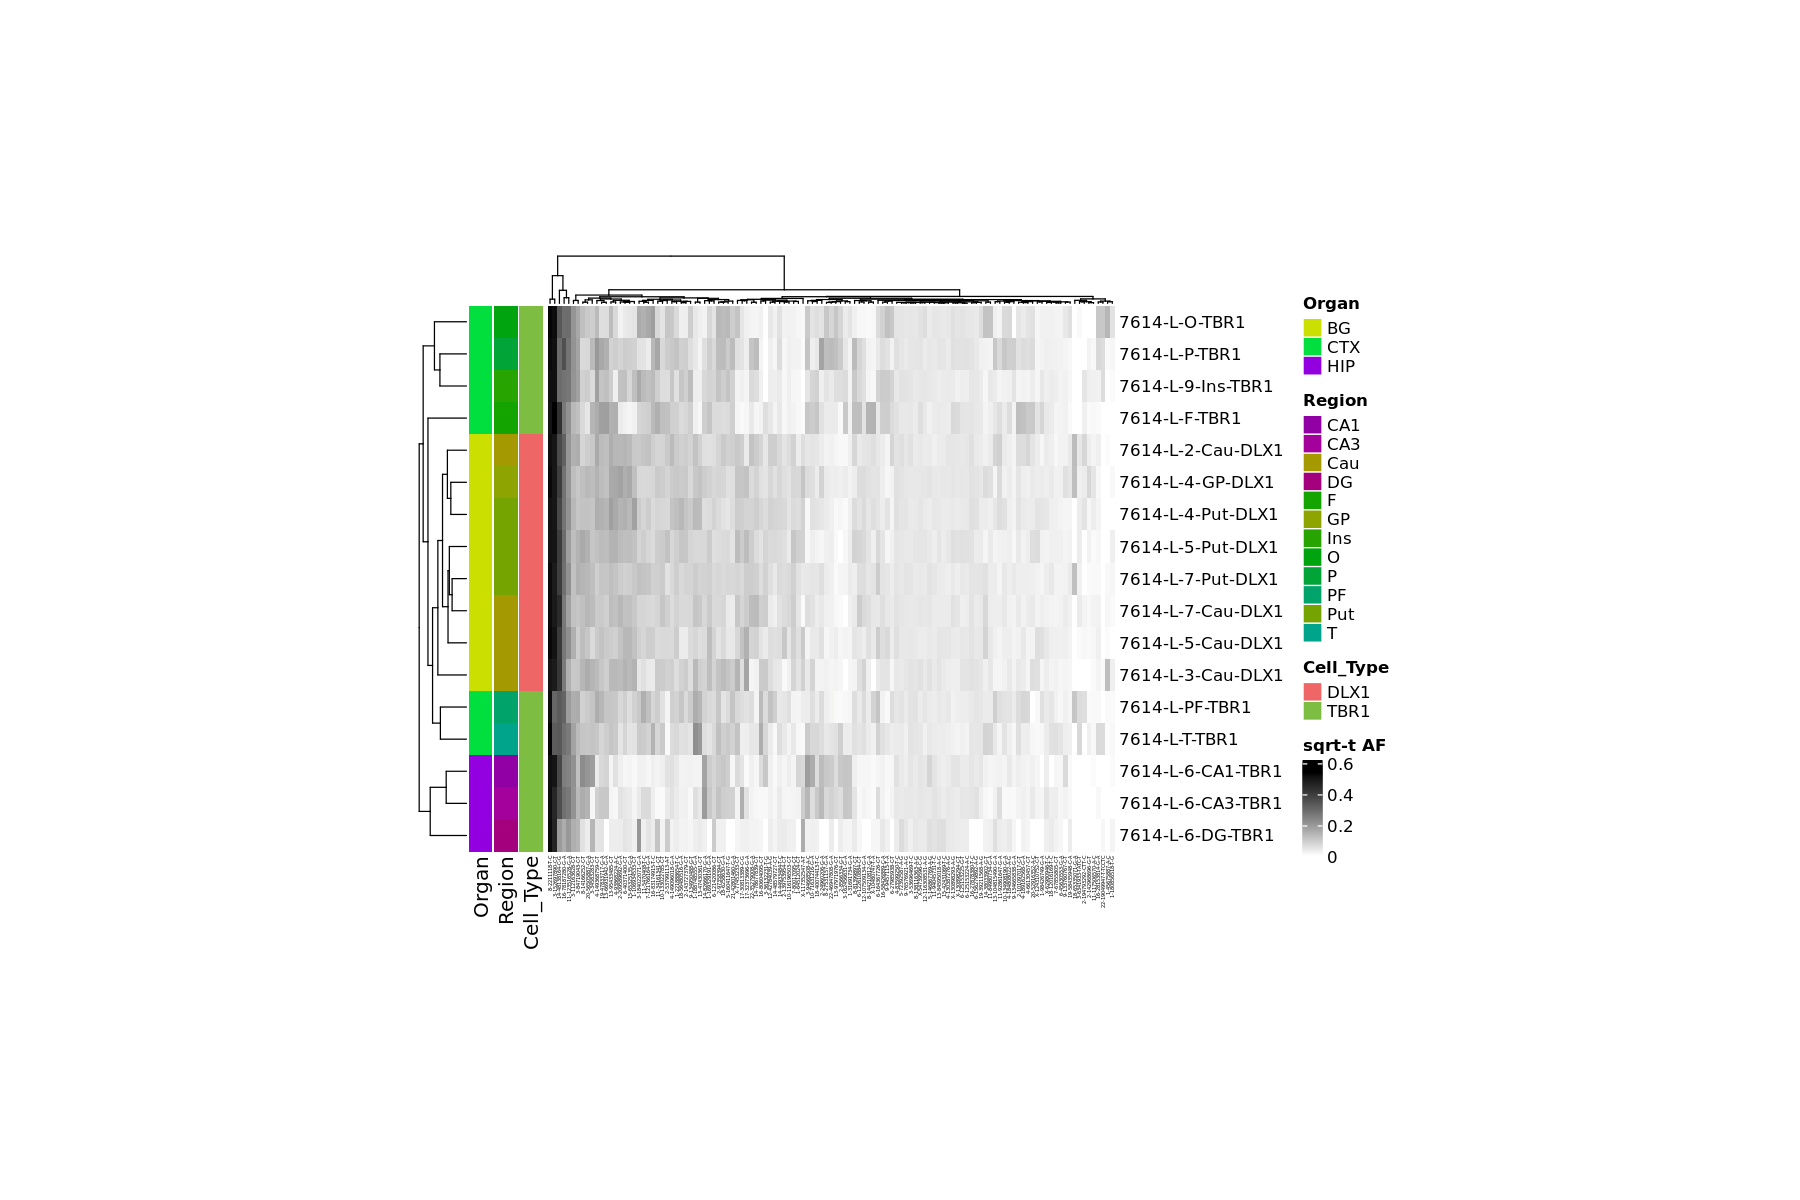

In [78]:
options(repr.plot.width = 15, repr.plot.height = 10)
p<-Heatmap(Normalized_casted_MAF_VarBySample2,
        col = c("white", "black"),
        row_names_gp = gpar(fontsize = "10"), column_names_gp = gpar(fontsize = "3"),
        name = "sqrt-t AF",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(12, "cm"),
        heatmap_height = unit(14, "cm")) 
p

In [79]:
pdf(file="7614_CTX_BG_HIP_SortedNu_SampleByVar_heatmap.pdf",height=50,width=50)
p
dev.off()

png 
  2

# Bias plot with sorted nuclei data

In [80]:
shared_variant_list<-variant_list[variant_list$sample_number_presented_CBH>0,]#sample_number_presented sample_number_presented_CBH>1,]
working_variants<-shared_variant_list$variant_list
CTX <- subset(melt_mtcars, Organ %in% c('CTX'))
BG <- subset(melt_mtcars, Organ %in% c('BG'))
HIP <- subset(melt_mtcars, Organ %in% c('HIP'))
length(working_variants)
sum(CTX$MAF, na.rm = TRUE)/length(CTX$MAF)
sum(BG$MAF, na.rm = TRUE)/length(BG$MAF)
sum(HIP$MAF, na.rm = TRUE)/length(HIP$MAF)

delta<-data.frame()
for (i in 1:length(working_variants)){
    xx<-subset(CTX, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(BG, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,1]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }

for (i in 1:length(working_variants)){
    xx<-subset(CTX, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(HIP, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,2]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }

[1] 121

[1] 0.07401287

[1] 0.07483342

[1] 0.05586287

In [81]:
nrow(delta)

[1] 121

In [82]:
mean(delta[,1])
mean(delta[,2])
SEM_X<-sd(delta[,1]) / sqrt(length(delta[,1]))
SEM_Y<-sd(delta[,2]) / sqrt(length(delta[,2]))
lowerX<-mean(delta[,1])-SEM_X
upperX<-mean(delta[,1])+SEM_X
lowerY<-mean(delta[,2])-SEM_Y
upperY<-mean(delta[,2])+SEM_Y

[1] 0.2604668

[1] 0.4092589

png 
  2

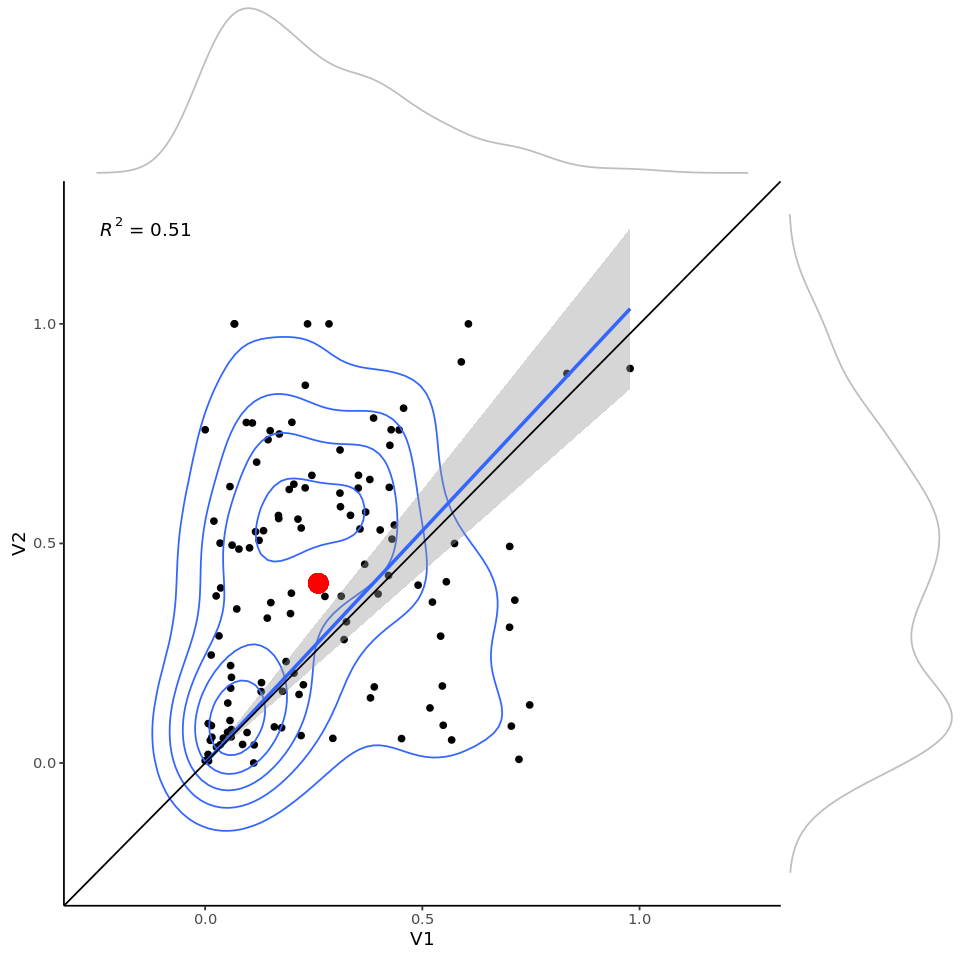

In [83]:
options(repr.plot.width = 8, repr.plot.height = 8)
formula <- y ~ x+0
p<-ggplot(delta, aes(x=V1, y=V2)) + geom_point()+xlim(-0.25,1.25)+ylim(-0.25,1.25)+theme_classic()+
    geom_density_2d()+stat_smooth(method = "lm", formula = y ~ x+0, geom = "smooth")+geom_abline(slope=1, intercept=0)+stat_poly_eq(formula = y ~ x+0,method = "lm")+
    geom_point(x = mean(delta[,1]), y = mean(delta[,2]), aes(x, y), size = 5, color = "red")
ggMarginal(p, color="grey", size=4)
pdf(file="7614_SortedNu_CTX_BG_HIP_bias_plot.pdf",height=8,width=8)
 ggMarginal(p, color="grey", size=4)
 dev.off()    

# Bar graph for CTX BG HIP shared variant number

In [84]:
data<-as.data.frame(c(40,6,5))
colnames(data)<-"number"
rownames(data)<-c("CTX-BG","BG-HIP","CTX-HIP")
data

,number
,<dbl>
CTX-BG,40
BG-HIP,6
CTX-HIP,5


In [85]:
xxx<-factor(rownames(data), level=c("CTX-BG","BG-HIP","CTX-HIP"))
options(repr.plot.width=5,repr.plot.height=6)
p<-ggplot(data=data, aes(x=xxx, y=number, fill=xxx)) +
geom_bar(colour="black",stat='identity')+theme_classic() + labs(x='Variant properties', colour = "Variant properties", fill="Variant properties")+
geom_text(aes(label=data$number, vjust = -0.5, size=2)) + theme(axis.text.x=element_text(angle=45, hjust=1))

In [86]:
pdf(file="7614_CTX_BG_HIP_exclusively_shared_var.pdf",height=6,width=5)
p
dev.off()

png 
  2

# Permutation test

In [122]:
set.seed(123)

In [126]:
temp2<-c()
Region_Celltype<-3
df<-as.data.frame(t(matrix(ncol=0,nrow=3)))
for (j in 1:10000){
    for (i in 1:51){
        vector <- rep(0, Region_Celltype)
        # Choose 10 random positions to place ones
        random_positions <- sample(1:3, 2)
        vector[random_positions] <- 1
        if(vector[1]+vector[2]==2){
            df<-rbind(df,c(1,0,0))
        }
        if(vector[2]+vector[3]==2){
            df<-rbind(df,c(0,1,0))
        }
        if(vector[1]+vector[3]==2){
            df<-rbind(df,c(0,0,1))
        }
    }
    temp2[j]<-sum(df[,1])
    df<-as.data.frame(t(matrix(ncol=0,nrow=3)))
}

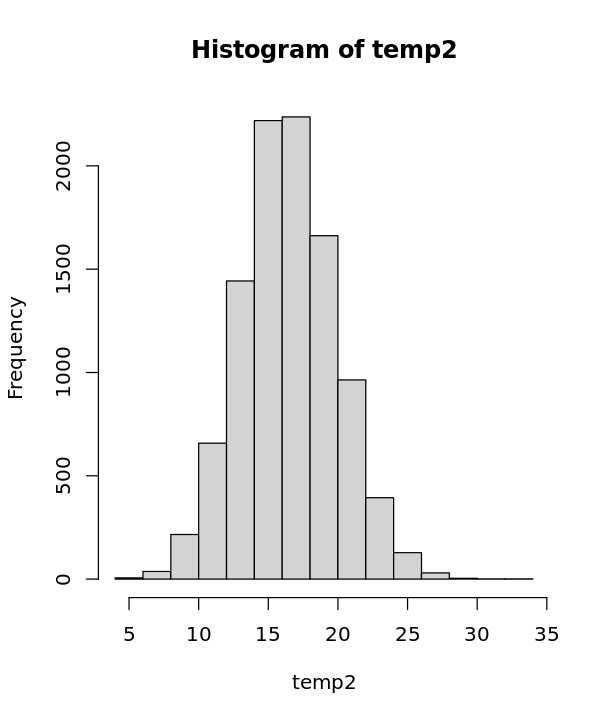

In [127]:
hist(temp2)

In [128]:
(length(temp2[temp2>=40])/length(temp2))*100

[1] 0